In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Read in Data
game_data = pd.read_csv('game_data.csv')
play_info = pd.read_csv('play_information.csv')
play_player_role = pd.read_csv('play_player_role_data.csv')
player_punt = pd.read_csv('player_punt_data.csv')
video_footage_control = pd.read_csv('video_footage-control.csv')
video_footage_injury = pd.read_csv('video_footage-injury.csv')
video_review = pd.read_csv('video_review.csv')

In [3]:
NGS_2016_pre = pd.read_csv('NGS-2016-pre.csv')
NGS_2016_post = pd.read_csv('NGS-2016-post.csv')
NGS_2017_pre = pd.read_csv('NGS-2017-pre.csv')
NGS_2017_post = pd.read_csv('NGS-2017-post.csv')

In [4]:
NGS_2016_wk1_6 = pd.read_csv('NGS-2016-reg-wk1-6.csv')
NGS_2016_wk7_12 = pd.read_csv('NGS-2016-reg-wk7-12.csv')
NGS_2016_wk13_17 = pd.read_csv('NGS-2016-reg-wk13-17.csv')
NGS_2017_wk1_6 = pd.read_csv('NGS-2017-reg-wk1-6.csv')
NGS_2017_wk7_12 = pd.read_csv('NGS-2017-reg-wk7-12.csv')
NGS_2017_wk13_17 = pd.read_csv('NGS-2017-reg-wk13-17.csv')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
NGS_2016 = pd.concat([NGS_2016_wk1_6, NGS_2016_wk7_12, NGS_2016_wk13_17])

In [8]:
NGS_2017 = pd.concat([NGS_2017_wk1_6, NGS_2017_wk7_12, NGS_2017_wk13_17])

In [9]:
NGS_df = pd.concat([NGS_2016, NGS_2017])

In [10]:
len(NGS_df)

51057522

In [11]:
NGS_df.head()

,Season_Year,GameKey,PlayID,GSISID,Time,x,y,dis,o,dir,Event
0,2016,66,2035,27675.0,2016-09-09 02:22:30.700,71.959999,30.809999,0.55,196.910004,282.000000,NaN
1,2016,66,2035,31550.0,2016-09-09 02:22:30.700,53.910000,29.980000,0.82,185.470001,275.890015,NaN
2,2016,66,2035,30463.0,2016-09-09 02:22:30.700,57.770000,22.260000,0.71,176.639999,267.309998,NaN
3,2016,66,2035,22824.0,2016-09-09 02:22:30.800,74.070000,26.910000,0.08,167.850006,19.540001,NaN
4,2016,66,2035,32994.0,2016-09-09 02:22:30.800,56.540001,33.080002,0.86,193.350006,285.429993,NaN


In [17]:
test_plot = NGS_2016.loc[(NGS_2016.PlayID == 2035) & (NGS_2016.GSISID == 27675)].sort_values('Time')

In [24]:
player_punt.loc[player_punt.GSISID == 27675]

,GSISID,Number,Position
1692,27675,84,TE


In [26]:
player_punt.head()

,GSISID,Number,Position
0,32069,36,SS
1,30095,11,WR
2,31586,22,FS
3,29520,35,SS
4,30517,51,OLB


In [27]:
play_player_role.loc[(play_player_role.GSISID == 27675) & (play_player_role.PlayID == 2035)]

,Season_Year,GameKey,PlayID,GSISID,Role
12737,2016,66,2035,27675,PLW


In [59]:
play_info.head()

,Season_Year,Season_Type,GameKey,Game_Date,Week,PlayID,Game_Clock,YardLine,Quarter,Play_Type,Poss_Team,Home_Team_Visit_Team,Score_Home_Visiting,PlayDescription
0,2016,Pre,2,08/13/2016,2,191,12:30,LA 47,1,Punt,LA,LA-DAL,0 - 7,"(12:30) J.Hekker punts 52 yards to DAL 1, Cent..."
1,2016,Pre,2,08/13/2016,2,1132,12:08,LA 29,2,Punt,LA,LA-DAL,7 - 21,"(12:08) J.Hekker punts 51 yards to DAL 20, Cen..."
2,2016,Pre,2,08/13/2016,2,1227,10:01,DAL 18,2,Punt,DAL,LA-DAL,7 - 21,"(10:01) C.Jones punts 40 yards to LA 42, Cente..."
3,2016,Pre,2,08/13/2016,2,1864,00:21,DAL 46,2,Punt,LA,LA-DAL,7 - 24,"(:21) J.Hekker punts 31 yards to DAL 15, Cente..."
4,2016,Pre,2,08/13/2016,2,2247,10:26,DAL 15,3,Punt,DAL,LA-DAL,14 - 24,"(10:26) M.Wile punts 40 yards to LA 45, Center..."


In [49]:
video_review.head()

,Season_Year,GameKey,PlayID,GSISID,Player_Activity_Derived,Turnover_Related,Primary_Impact_Type,Primary_Partner_GSISID,Primary_Partner_Activity_Derived,Friendly_Fire
0,2016,5,3129,31057,Tackling,No,Helmet-to-body,32482,Tackled,No
1,2016,21,2587,29343,Blocked,No,Helmet-to-helmet,31059,Blocking,No
2,2016,29,538,31023,Tackling,No,Helmet-to-body,31941,Tackled,No
3,2016,45,1212,33121,Tackling,No,Helmet-to-body,28249,Tackled,No
4,2016,54,1045,32444,Blocked,No,Helmet-to-body,31756,Blocked,Yes


In [121]:
video_footage_injury.iloc[0,9]

'http://a.video.nfl.com//films/vodzilla/153233/Kadeem_Carey_punt_return-Vwgfn5k9-20181119_152809972_5000k.mp4'

#### Who's getting hurt?

In [50]:
merged_df = video_review.merge(play_player_role, how= 'left', left_on=['GSISID','PlayID','GameKey'], right_on=['GSISID','PlayID','GameKey'])

In [71]:
player_punt.loc[player_punt.GSISID == 32482]

,GSISID,Number,Position
1411,32482,2,WR
2335,32482,45,WR


In [77]:
play_player_role.loc[(play_player_role.GSISID == 29343) & (play_player_role.PlayID == 2587)]

,Season_Year,GameKey,PlayID,GSISID,Role
38698,2016,21,2587,29343,GL


In [53]:
merged_df.Role.value_counts()

PR      5
GL      4
PLW     4
PLG     4
PRG     4
PLS     2
PLT     2
PRW     2
PRT     2
PDR1    1
GR      1
P       1
PFB     1
PLL     1
PDL2    1
PPR     1
VR      1
Name: Role, dtype: int64

In [55]:
len(video_footage_injury)

37

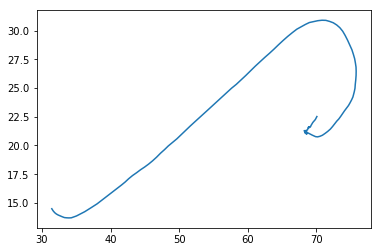

In [34]:
ax = plt.plot(test_plot['x'],test_plot['y'])

In [163]:
gunner_df = NGS_2016_pre.loc[(NGS_2016_pre.GameKey == 5) & (NGS_2016_pre.PlayID == 3129) & (NGS_2016_pre.GSISID == 31057)].sort_values('Time')

In [164]:
min(gunner_df['Time'])

'2016-08-12 02:07:25.100'

In [162]:
max(gunner_df['Time'])

'2016-08-12 02:07:51.900'

In [172]:
gunner_df.head(11).dis.sum() * 2.045

1.6360000015236438

In [283]:
gunner_df.head()

,Season_Year,GameKey,PlayID,GSISID,Time,x,y,dis,o,dir,Event,mph,dis_per_second,dis_mph
205793,2016,5,3129,31057.0,2016-08-12 02:07:25.100,83.470001,22.209999,0.06,155.649994,307.399994,punt_play,1.2270,0.6,1.22730
200997,2016,5,3129,31057.0,2016-08-12 02:07:25.200,83.410004,22.270000,0.08,157.279999,308.329987,NaN,1.6360,0.8,1.63640
201008,2016,5,3129,31057.0,2016-08-12 02:07:25.300,83.370003,22.330000,0.08,158.350006,310.489990,NaN,1.6360,0.8,1.63640
200190,2016,5,3129,31057.0,2016-08-12 02:07:25.400,83.320000,22.379999,0.06,159.360001,310.209991,NaN,1.2270,0.6,1.22730
200201,2016,5,3129,31057.0,2016-08-12 02:07:25.500,83.279999,22.400000,0.05,160.179993,309.279999,NaN,1.0225,0.5,1.02275


In [186]:
gunner_df['dis_per_second'] = gunner_df.dis * 10
gunner_df['dis_mph'] = gunner_df['dis_per_second'] * 2.0455

In [282]:
print(gunner_df.dis_mph[200:250])

202139    18.000400
202150    18.000400
202161    18.409500
202172    18.409500
202183    18.409500
202194    18.409500
202205    17.795850
202783    17.795850
202440    17.795850
202694    17.795850
202705    16.977650
202716    16.977650
202727    16.364000
202738    16.364000
202749    16.773100
202760    16.773100
202771    15.954899
202111    15.954899
202122    15.341250
202619    15.341250
202630    14.932150
202641    14.932150
202652    14.932150
202663    14.932150
202674    14.523050
202685    14.523050
202029    16.159450
202040    12.273000
202456     9.204750
202467     6.341050
202478     4.500100
202489     5.522850
205809     5.113750
202500     5.318300
202511     4.909200
202522     3.681900
203262     3.068250
201935     2.250050
201946     1.636400
201957     1.022750
202859     0.818200
202870     0.818200
202881     1.636400
202892     1.431850
202903     1.431850
202914     2.045500
202277     1.431850
202287     0.818200
202945     0.818200
202955     1.431850


In [126]:
play_player_role.loc[(play_player_role.GameKey == 5) & (play_player_role.PlayID == 3129) & (play_player_role.GSISID == 31057)]

,Season_Year,GameKey,PlayID,GSISID,Role
62728,2016,5,3129,31057,PLW


(0, 53.3)

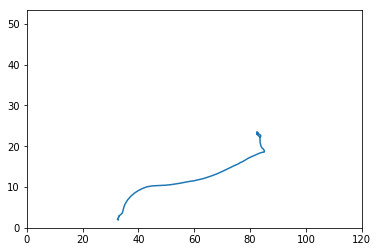

In [120]:
ax1 = plt.subplot()
ax1.plot(gunner_df['x'], gunner_df['y'])
ax1.set_xlim([0,120])
ax1.set_ylim([0,53.3])

In [91]:
max(NGS_2016_wk1_6['y'])

67.089996337890639

In [134]:
play_info['fair_catch'] = play_info.PlayDescription.str.contains('fair catch')

In [137]:
play_info.loc[play_info.fair_catch == True].merge(video_review)

,Season_Year,Season_Type,GameKey,Game_Date,Week,PlayID,Game_Clock,YardLine,Quarter,Play_Type,...,Score_Home_Visiting,PlayDescription,fair_catch,GSISID,Player_Activity_Derived,Turnover_Related,Primary_Impact_Type,Primary_Partner_GSISID,Primary_Partner_Activity_Derived,Friendly_Fire
0,2016,Reg,280,12/18/2016,15,2918,03:36,JAX 21,3,Punt,...,8 - 20,"(3:36) B.Nortman punts 49 yards to HST 30, Cen...",True,32120,Blocking,No,Helmet-to-body,32725,Blocked,No
1,2017,Reg,607,12/14/2017,15,978,14:11,DEN 38,2,Punt,...,7 - 0,(14:11) (Punt formation) R.Sanchez punts 27 ya...,True,29793,Blocking,No,Helmet-to-helmet,32114,Blocked,No


In [160]:
video_footage_injury.loc[video_footage_injury.playid == 2918]

,season,Type,Week,Home_team,Visit_Team,Qtr,PlayDescription,gamekey,playid,PREVIEW LINK (5000K)
13,2016,Reg,15,Houston Texans,Jacksonville Jaguars,3,"(3:36) B.Nortman punts 49 yards to HST 30, Cen...",280,2918,http://a.video.nfl.com//films/vodzilla/153245/...


In [142]:
video_footage_injury.head()

,season,Type,Week,Home_team,Visit_Team,Qtr,PlayDescription,gamekey,playid,PREVIEW LINK (5000K)
0,2016,Pre,2,Chicago Bears,Denver Broncos,3,(3:44) (Punt formation) P.O'Donnell punts 58 y...,5,3129,http://a.video.nfl.com//films/vodzilla/153233/...
1,2016,Pre,3,Tennessee Titans,Carolina Panthers,3,(5:52) (Punt formation) K.Redfern punts 36 yar...,21,2587,http://a.video.nfl.com//films/vodzilla/153234/...
2,2016,Pre,3,Washington Redskins,New York Jets,1,"(4:46) L.Edwards punts 51 yards to WAS 27, Cen...",29,538,http://a.video.nfl.com//films/vodzilla/153235/...
3,2016,Pre,4,New York Jets,New York Giants,2,"(8:29) B.Wing punts 44 yards to NYJ 10, Center...",45,1212,http://a.video.nfl.com//films/vodzilla/153236/...
4,2016,Pre,5,Detroit Lions,Buffalo Bills,1,"(:38) C.Schmidt punts 46 yards to DET 8, Cente...",60,905,http://a.video.nfl.com//films/vodzilla/153237/...


### Does speed correlate with injury?

In [189]:
video_review.head()

,Season_Year,GameKey,PlayID,GSISID,Player_Activity_Derived,Turnover_Related,Primary_Impact_Type,Primary_Partner_GSISID,Primary_Partner_Activity_Derived,Friendly_Fire
0,2016,5,3129,31057,Tackling,No,Helmet-to-body,32482,Tackled,No
1,2016,21,2587,29343,Blocked,No,Helmet-to-helmet,31059,Blocking,No
2,2016,29,538,31023,Tackling,No,Helmet-to-body,31941,Tackled,No
3,2016,45,1212,33121,Tackling,No,Helmet-to-body,28249,Tackled,No
4,2016,54,1045,32444,Blocked,No,Helmet-to-body,31756,Blocked,Yes


In [198]:
injury_ngs = video_review.merge(NGS_2016, how ='inner', left_on=['GSISID','PlayID','GameKey'], right_on=['GSISID','PlayID','GameKey'])

In [200]:
injury_ngs['dis_per_second'] = injury_ngs.dis * 10
injury_ngs['dis_mph'] = injury_ngs.dis_per_second * 2.0455

In [204]:
injury_ngs.groupby('PlayID')['dis_mph'].agg(max)

PlayID
1526    18.000400
1976    17.591300
2341    19.432250
2342    20.864100
2667    21.068649
2902    13.500301
2918     5.727400
3278    18.409500
3468    17.795850
3509    13.909400
3609    19.432250
3663    10.841149
3746    19.432250
Name: dis_mph, dtype: float64

In [208]:
play_info.head()

,Season_Year,Season_Type,GameKey,Game_Date,Week,PlayID,Game_Clock,YardLine,Quarter,Play_Type,Poss_Team,Home_Team_Visit_Team,Score_Home_Visiting,PlayDescription,fair_catch
0,2016,Pre,2,08/13/2016,2,191,12:30,LA 47,1,Punt,LA,LA-DAL,0 - 7,"(12:30) J.Hekker punts 52 yards to DAL 1, Cent...",False
1,2016,Pre,2,08/13/2016,2,1132,12:08,LA 29,2,Punt,LA,LA-DAL,7 - 21,"(12:08) J.Hekker punts 51 yards to DAL 20, Cen...",True
2,2016,Pre,2,08/13/2016,2,1227,10:01,DAL 18,2,Punt,DAL,LA-DAL,7 - 21,"(10:01) C.Jones punts 40 yards to LA 42, Cente...",False
3,2016,Pre,2,08/13/2016,2,1864,00:21,DAL 46,2,Punt,LA,LA-DAL,7 - 24,"(:21) J.Hekker punts 31 yards to DAL 15, Cente...",False
4,2016,Pre,2,08/13/2016,2,2247,10:26,DAL 15,3,Punt,DAL,LA-DAL,14 - 24,"(10:26) M.Wile punts 40 yards to LA 45, Center...",False


In [221]:
play_info = play_info.merge(video_review[['GameKey','PlayID','GSISID']], how = 'left', left_on = ['GameKey','PlayID'], right_on = ['GameKey','PlayID'])

In [227]:
play_info['injury'] = play_info.GSISID.apply(lambda x: 0 if pd.isnull(x) else 1)

In [239]:
play_info.fair_catch.value_counts(normalize = True)

False    0.751684
True     0.248316
Name: fair_catch, dtype: float64

In [244]:
play_info.loc[play_info.injury == 1]['fair_catch'].sum() / len(play_info.loc[play_info.injury == 1])

0.054054054054054057

In [245]:
play_info.loc[play_info.injury == 1]['fair_catch'].sum() / len(play_info.loc[play_info.injury == 0])

0.00030102347983142685

In [254]:
fair_catches = play_info.loc[play_info.fair_catch == 1]
non_fair_catches = play_info.loc[play_info.fair_catch == 0]

In [258]:
len(fair_catches.loc[fair_catches.injury == 1]) / float(len(fair_catches)) * 100

0.12055455093429776

In [257]:
len(non_fair_catches.loc[non_fair_catches.injury == 1]) / float(len(non_fair_catches)) * 100

0.6969334926324173

In [259]:
(.7-.12) / .12

4.833333333333333

#### Nearly 5 times more likely to have an injury when there is an actual return

In [7]:
import plotly

In [8]:
import plotly.graph_objs as go
from plotly import offline
import plotly.plotly as py
plotly.tools.set_credentials_file(username='mtodisco10', api_key='bCfUmq5FralbymKXY4uX')

In [9]:
def load_layout():
    """
    Returns a dict for a Football themed Plot.ly layout 
    """
    layout = dict(
        title = "Player Activity",
        plot_bgcolor='darkseagreen',
        showlegend=True,
        xaxis=dict(
            autorange=False,
            range=[0, 120],
            showgrid=False,
            zeroline=False,
            showline=True,
            linecolor='black',
            linewidth=1,
            mirror=True,
            ticks='',
            tickmode='array',
            tickvals=[10,20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
            ticktext=['Goal', 10, 20, 30, 40, 50, 40, 30, 20, 10, 'Goal'],
            showticklabels=True
        ),
        yaxis=dict(
            title='',
            autorange=False,
            range=[-3.3,56.3],
            showgrid=False,
            zeroline=False,
            showline=True,
            linecolor='black',
            linewidth=1,
            mirror=True,
            ticks='',
            showticklabels=False
        ),
        shapes=[
            dict(
                type='line',
                layer='below',
                x0=0,
                y0=0,
                x1=120,
                y1=0,
                line=dict(
                    color='white',
                    width=2
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=0,
                y0=53.3,
                x1=120,
                y1=53.3,
                line=dict(
                    color='white',
                    width=2
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=10,
                y0=0,
                x1=10,
                y1=53.3,
                line=dict(
                    color='white',
                    width=10
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=20,
                y0=0,
                x1=20,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=30,
                y0=0,
                x1=30,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=40,
                y0=0,
                x1=40,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=50,
                y0=0,
                x1=50,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=60,
                y0=0,
                x1=60,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),dict(
                type='line',
                layer='below',
                x0=70,
                y0=0,
                x1=70,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),dict(
                type='line',
                layer='below',
                x0=80,
                y0=0,
                x1=80,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=90,
                y0=0,
                x1=90,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),dict(
                type='line',
                layer='below',
                x0=100,
                y0=0,
                x1=100,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=110,
                y0=0,
                x1=110,
                y1=53.3,
                line=dict(
                    color='white',
                    width=10
                )
            )
        ]
    )
    return layout

layout = load_layout()

In [19]:
# Loading and plotting functions

def load_plays_for_game(GameKey):
    """
    Returns a dataframe of play data for a given game (GameKey)
    """
    play_information = pd.read_csv('play_information.csv')
    play_information = play_information[play_information['GameKey'] == GameKey]
    return play_information


def load_game_and_ngs(ngs_file=None, GameKey=None):
    """
    Returns a dataframe of player movements (NGS data) for a given game
    """
    if ngs_file is None:
        print("Specifiy an NGS file.")
        return None
    if GameKey is None:
        print('Specify a GameKey')
        return None
    # Merge play data with NGS data    
    plays = load_plays_for_game(GameKey)
    ngs = pd.read_csv(ngs_file, low_memory=False)
    merged = pd.merge(ngs, plays, how="inner", on=["GameKey", "PlayID", "Season_Year"])
    return merged


def plot_play(game_df, PlayID, player1=None, player2=None, custom_layout=False):
    """
    Plots player movements on the field for a given game, play, and two players
    """
    game_df = game_df[game_df.PlayID==PlayID]
    
    GameKey=str(pd.unique(game_df.GameKey)[0])
    HomeTeam = pd.unique(game_df.Home_Team_Visit_Team)[0].split("-")[0]
    VisitingTeam = pd.unique(game_df.Home_Team_Visit_Team)[0].split("-")[1]
    YardLine = game_df[(game_df.PlayID==PlayID) & (game_df.GSISID==player1)]['YardLine'].iloc[0]
    
    traces=[]   
    if (player1 is not None) & (player2 is not None):
        game_df = game_df[ (game_df['GSISID']==player1) | (game_df['GSISID']==player2)]
        for player in pd.unique(game_df.GSISID):
            player = int(player)
            trace = go.Scatter(
                x = game_df[game_df.GSISID==player].x,
                y = game_df[game_df.GSISID==player].y,
                name='GSISID '+str(player),
                mode='markers'
            )
            traces.append(trace)
    else:
        print("Specify GSISIDs for player1 and player2")
        return None
    
    if custom_layout is not True:
        layout = load_layout()
        layout['title'] =  HomeTeam + \
        ' vs. ' + VisitingTeam + \
        '<br>Possession: ' + \
        YardLine.split(" ")[0] +'@'+YardLine.split(" ")[1]
    data = traces
    fig = dict(data=data, layout=layout)
    play_description = game_df[(game_df.PlayID==PlayID) & (game_df.GSISID==player1)].iloc[0]["PlayDescription"]
    print("\n\n\t",play_description)
    #py.iplot(fig,filename='jupyter-table1')
    offline.iplot(fig)

In [15]:
game280 = load_game_and_ngs('NGS-2016-reg-wk13-17.csv',GameKey=280)

In [25]:
plot_play(game_df=game280, PlayID=2918, player1=32120, player2=32725)